ESTÉ CÓDIGO ABRE UN STRADDLE A LA APERTURA DEL MERCADO, PERO CUANDO EL PRECIO ROMPE POR ARRIBA EL RANGO INICIAL CON FUERZA, 
SE HEDGEA LA POSICIÓN CON LA VENTA DE UNA PUT

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import requests
import os
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import brentq
import scipy.stats as si
from scipy.stats import norm
import matplotlib.patches as patches
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.patches as patches
API_KEY = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
us_holidays = holidays.US(years=2024)
dst_start = pd.to_datetime('2024-03-10')
dst_end = pd.to_datetime('2024-11-03')
fila =6 # Determina el ancho de la caja en la que buscaremos el máx y el mín.
# no confundir fila que determina la caja del IB con row que determina el núm. de índice cuando la caja es rota.

In [2]:
# Define the URL
url = 'https://api.polygon.io/v2/aggs/ticker/O:SPY241220P00582000/range/1/minute/2024-12-20/2024-12-20?apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
#url = 'https://api.polygon.io/v2/aggs/ticker/O:QQQ241108P00516000/range/1/minute/2024-11-08/2024-11-08?apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
#url = 'https://api.polygon.io/v2/aggs/ticker/I:NDX/range/1/second/2023-03-13/2023-03-24?sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
# Make the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Check if 'results' is in the data
    if 'results' in data:
        # Convert the 'results' into a DataFrame
        df_P = pd.DataFrame(data['results'])
        
        # Convert the timestamp from milliseconds to a human-readable format
        df_P['t'] = pd.to_datetime(df_P['t'], unit='ms')
        df_P.rename(columns={'t': 'timestamp'}, inplace=True)
        
        # Display the DataFrame
        print(df_P)
    else:
        print("No data found in the response.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}, Message: {response.text}")

        v      vw     o     c     h     l           timestamp    n
0     960  2.6152  2.42  2.66  2.78  2.42 2024-12-20 14:30:00  141
1     526  2.3814  2.62  2.13  2.62  2.11 2024-12-20 14:31:00  122
2    1180  2.3532  2.12  2.32  2.52  2.11 2024-12-20 14:32:00  230
3     314  2.2213  2.33  2.23  2.38  2.10 2024-12-20 14:33:00   75
4     329  2.1276  2.21  2.14  2.30  1.96 2024-12-20 14:34:00  102
..    ...     ...   ...   ...   ...   ...                 ...  ...
372   814  0.0101  0.01  0.01  0.02  0.01 2024-12-20 20:59:00   52
373     2  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:00:00    1
374     5  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:01:00    1
375     2  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:03:00    1
376    10  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:09:00    1

[377 rows x 8 columns]


In [3]:
df_P = df_P[['timestamp','c']]

In [4]:
# Define the URL
url = 'https://api.polygon.io/v2/aggs/ticker/O:SPY241220C00582000/range/1/minute/2024-12-20/2024-12-20?apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
#url = 'https://api.polygon.io/v2/aggs/ticker/O:QQQ241108P00516000/range/1/minute/2024-11-08/2024-11-08?apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
#url = 'https://api.polygon.io/v2/aggs/ticker/I:NDX/range/1/second/2023-03-13/2023-03-24?sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
# Make the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Check if 'results' is in the data
    if 'results' in data:
        # Convert the 'results' into a DataFrame
        df_C = pd.DataFrame(data['results'])
        
        # Convert the timestamp from milliseconds to a human-readable format
        df_C['t'] = pd.to_datetime(df_C['t'], unit='ms')
        df_C.rename(columns={'t': 'timestamp'}, inplace=True)
        
        # Display the DataFrame
        print(df_C)
    else:
        print("No data found in the response.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}, Message: {response.text}")

        v       vw      o      c      h      l           timestamp    n
0    1423   2.0785   2.27   2.09   2.28   1.95 2024-12-20 14:30:00  193
1    1648   2.2692   2.11   2.38   2.40   2.11 2024-12-20 14:31:00  289
2     789   2.1478   2.38   2.22   2.39   1.98 2024-12-20 14:32:00  211
3    1044   2.2933   2.21   2.30   2.40   2.12 2024-12-20 14:33:00  198
4    1382   2.4270   2.29   2.41   2.59   2.18 2024-12-20 14:34:00  254
..    ...      ...    ...    ...    ...    ...                 ...  ...
213     1  10.1000  10.10  10.10  10.10  10.10 2024-12-20 21:03:00    1
214     2   9.9700   9.97   9.97   9.97   9.97 2024-12-20 21:04:00    1
215     5   9.7300   9.73   9.73   9.73   9.73 2024-12-20 21:06:00    2
216     1   9.5100   9.51   9.51   9.51   9.51 2024-12-20 21:07:00    1
217     1   8.5700   8.57   8.57   8.57   8.57 2024-12-20 21:14:00    1

[218 rows x 8 columns]


In [5]:
df_C = df_C[['timestamp','c']]

In [6]:
# Define the URL
url = 'https://api.polygon.io/v2/aggs/ticker/O:SPY241220P00584000/range/1/minute/2024-12-20/2024-12-20?apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
#url = 'https://api.polygon.io/v2/aggs/ticker/O:QQQ241108P00516000/range/1/minute/2024-11-08/2024-11-08?apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
#url = 'https://api.polygon.io/v2/aggs/ticker/I:NDX/range/1/second/2023-03-13/2023-03-24?sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
# Make the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Check if 'results' is in the data
    if 'results' in data:
        # Convert the 'results' into a DataFrame
        df_P_589 = pd.DataFrame(data['results'])
        
        # Convert the timestamp from milliseconds to a human-readable format
        df_P_589['t'] = pd.to_datetime(df_P_589['t'], unit='ms')
        df_P_589.rename(columns={'t': 'timestamp'}, inplace=True)
        
        # Display the DataFrame
        print(df_P_589)
    else:
        print("No data found in the response.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}, Message: {response.text}")

       v      vw     o     c     h     l           timestamp   n
0    357  3.7762  3.56  4.00  4.00  3.51 2024-12-20 14:30:00  84
1    216  3.4081  3.83  3.18  3.83  3.18 2024-12-20 14:31:00  50
2     56  3.3723  3.16  3.43  3.75  3.16 2024-12-20 14:32:00  21
3    105  3.3392  3.44  3.30  3.54  3.18 2024-12-20 14:33:00  29
4     49  3.2978  3.40  3.23  3.40  3.09 2024-12-20 14:34:00  14
..   ...     ...   ...   ...   ...   ...                 ...  ..
377  157  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:00:00  10
378  147  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:01:00   7
379   76  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:02:00   9
380  734  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:03:00   4
381    1  0.0100  0.01  0.01  0.01  0.01 2024-12-20 21:06:00   1

[382 rows x 8 columns]


In [7]:
df_P_589
df_P_589 = df_P_589[['timestamp','c']]

In [8]:
# Define the URL
url = 'https://api.polygon.io/v2/aggs/ticker/SPY/range/1/minute/2024-12-20/2024-12-20?apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
#url = 'https://api.polygon.io/v2/aggs/ticker/O:QQQ241108P00516000/range/1/minute/2024-11-08/2024-11-08?apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
#url = 'https://api.polygon.io/v2/aggs/ticker/I:NDX/range/1/second/2023-03-13/2023-03-24?sort=asc&apiKey=HsOX1rl8t3B1AJfl4O2uqscUp372l7EF'
# Make the API request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Check if 'results' is in the data
    if 'results' in data:
        # Convert the 'results' into a DataFrame
        spy = pd.DataFrame(data['results'])
        
        # Convert the timestamp from milliseconds to a human-readable format
        spy['t'] = pd.to_datetime(spy['t'], unit='ms')
        spy.rename(columns={'t': 'timestamp'}, inplace=True)
        
        # Display the DataFrame
        print(spy)
    else:
        print("No data found in the response.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}, Message: {response.text}")

           v        vw       o       c       h       l           timestamp  \
0     8018.0  581.3285  581.98  581.28  581.98  581.27 2024-12-20 09:00:00   
1     2804.0  581.1019  581.24  580.95  581.24  580.95 2024-12-20 09:01:00   
2      845.0  580.8841  580.98  580.82  580.98  580.82 2024-12-20 09:02:00   
3      504.0  580.6638  580.73  580.50  580.73  580.50 2024-12-20 09:03:00   
4     4876.0  580.5308  580.50  580.50  580.54  580.50 2024-12-20 09:04:00   
..       ...       ...     ...     ...     ...     ...                 ...   
904    316.0  592.1164  592.11  592.12  592.12  592.11 2024-12-21 00:55:00   
905   1298.0  592.1156  592.11  592.12  592.12  592.11 2024-12-21 00:56:00   
906   6340.0  592.1190  592.12  592.12  592.12  592.10 2024-12-21 00:57:00   
907   4072.0  592.1183  592.12  592.12  592.12  592.11 2024-12-21 00:58:00   
908  10168.0  592.1192  592.11  592.12  592.12  592.11 2024-12-21 00:59:00   

       n  
0    262  
1     77  
2     67  
3     53  
4     60

In [9]:
spy = spy[['timestamp','c']]
spy['c'] = round(spy['c'], 1)
spy.rename(columns={'c': 'spy'}, inplace=True)
spy

,timestamp,spy
0,2024-12-20 09:00:00,581.3
1,2024-12-20 09:01:00,581.0
2,2024-12-20 09:02:00,580.8
3,2024-12-20 09:03:00,580.5
4,2024-12-20 09:04:00,580.5
...,...,...
904,2024-12-21 00:55:00,592.1
905,2024-12-21 00:56:00,592.1
906,2024-12-21 00:57:00,592.1
907,2024-12-21 00:58:00,592.1


In [10]:
import pandas as pd

# Example: Join df_P, df_C, and df_P_589 on the 'timestamp' column

df = (
    df_P.merge(df_C, on='timestamp', how='inner')
        .merge(df_P_589, on='timestamp', how='inner')
        .merge(spy, on='timestamp', how='inner')
)


df.rename(columns={'c_x': 'Close_P', 'c_y': 'Close_C', 'c': 'Close_589'}, inplace=True)
df

,timestamp,Close_P,Close_C,Close_589,spy
0,2024-12-20 14:30:00,2.66,2.09,4.00,581.4
1,2024-12-20 14:31:00,2.13,2.38,3.18,582.2
2,2024-12-20 14:32:00,2.32,2.22,3.43,581.8
3,2024-12-20 14:33:00,2.23,2.30,3.30,582.0
4,2024-12-20 14:34:00,2.14,2.41,3.23,582.3
...,...,...,...,...,...
200,2024-12-20 20:53:00,0.02,8.00,0.01,589.9
201,2024-12-20 20:57:00,0.01,7.84,0.01,589.8
202,2024-12-20 20:58:00,0.01,8.13,0.01,590.1
203,2024-12-20 21:01:00,0.01,10.30,0.01,592.4


In [11]:
df.loc[df['timestamp'].dt.time <= pd.Timestamp('15:12').time(), 'Close_589'] = 0

df['Net_balance'] = (df['Close_P'] + df['Close_C'])
df['Net_balance'] = (df['Close_P'] + df['Close_C']) -  df.loc[0, 'Net_balance']

row_spike = df[df['timestamp'].dt.time == pd.Timestamp('15:13').time()]
print(row_spike)
if not row_spike.empty:
    df['net_row_spike'] = df['Close_589'] - row_spike.iloc[0]['Close_589']
else:
    df['net_row_spike'] = None  

df.loc[df['timestamp'].dt.time <= pd.Timestamp('15:12').time(), 'net_row_spike'] = 0

df['Premium'] = df['Net_balance'] + df['net_row_spike']
pd.set_option('display.max_rows', None)
df

             timestamp  Close_P  Close_C  Close_589    spy  Net_balance
43 2024-12-20 15:13:00     1.06     3.38       1.72  584.3        -0.31


,timestamp,Close_P,Close_C,Close_589,spy,Net_balance,net_row_spike,Premium
0,2024-12-20 14:30:00,2.66,2.09,0.00,581.4,0.00,0.00,0.00
1,2024-12-20 14:31:00,2.13,2.38,0.00,582.2,-0.24,0.00,-0.24
2,2024-12-20 14:32:00,2.32,2.22,0.00,581.8,-0.21,0.00,-0.21
3,2024-12-20 14:33:00,2.23,2.30,0.00,582.0,-0.22,0.00,-0.22
4,2024-12-20 14:34:00,2.14,2.41,0.00,582.3,-0.20,0.00,-0.20
5,2024-12-20 14:35:00,2.13,2.36,0.00,582.2,-0.26,0.00,-0.26
6,2024-12-20 14:36:00,2.27,2.13,0.00,581.8,-0.35,0.00,-0.35
7,2024-12-20 14:37:00,1.90,2.65,0.00,582.8,-0.20,0.00,-0.20
8,2024-12-20 14:38:00,1.73,2.74,0.00,583.0,-0.28,0.00,-0.28
9,2024-12-20 14:39:00,1.38,3.51,0.00,584.1,0.14,0.00,0.14


In [12]:
#filtrado del dataframe a sólo las primeras filas
df = df.iloc[:20000]

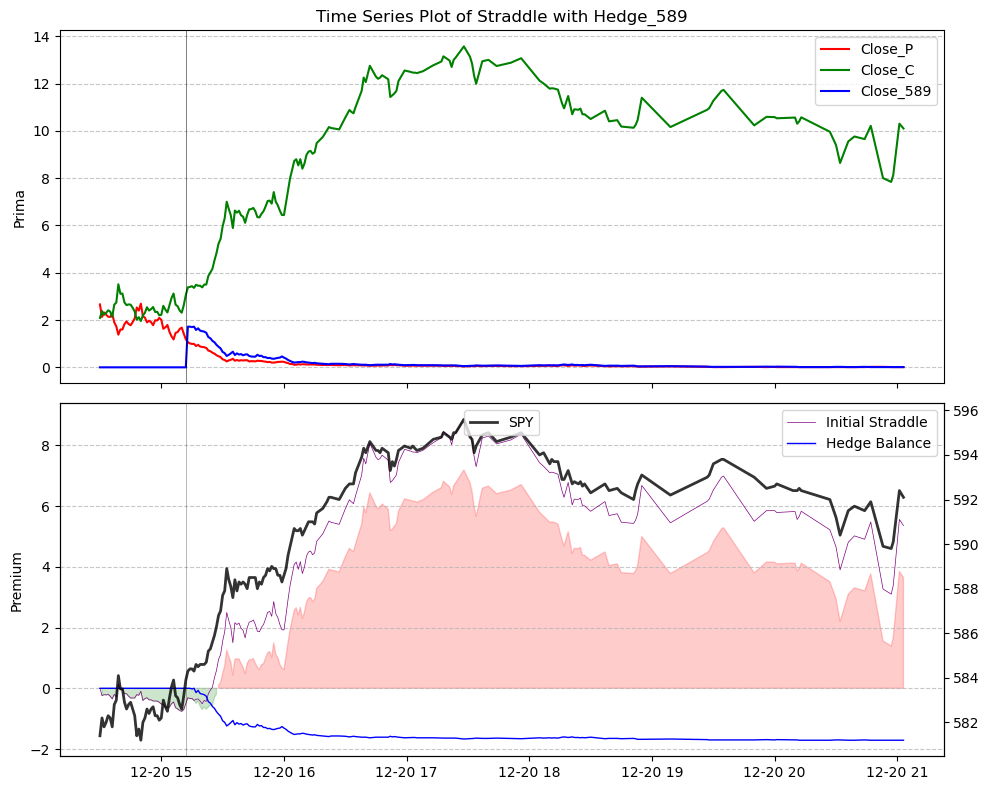

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].plot(df['timestamp'], df['Close_P'], label='Close_P', color='r')
axs[0].plot(df['timestamp'], df['Close_C'], label='Close_C', color='g')
axs[0].plot(df['timestamp'], df['Close_589'], label='Close_589', color='b')

axs[0].set_ylabel('Prima')
axs[0].set_title('Time Series Plot of Straddle with Hedge_589')
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.7)
axs[0].axvline(pd.Timestamp('2024-12-20 15:12'), color='black',alpha=0.7, linewidth = 0.5)

ax2 = axs[1].twinx()
ax2.plot(df['timestamp'], df['spy'], label='SPY', color='black',  alpha=0.8, linewidth=2)

axs[1].fill_between(
    df['timestamp'], 
    df['Premium'], 
    where=(df['Premium'] >= 0), 
    color='red', 
    alpha=0.2, 
)
axs[1].fill_between(
    df['timestamp'], 
    df['Premium'], 
    where=(df['Premium'] < 0), 
    color='green', 
    alpha=0.2, 
)
ax2.legend(loc='upper center')   
axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].plot(df['timestamp'], df['Net_balance'], label='Initial Straddle', color='purple', linewidth=0.5)
axs[1].plot(df['timestamp'], df['net_row_spike'], label='Hedge Balance', color='blue', linewidth=1)

axs[1].grid(axis='y', linestyle='--', alpha=0.7)
axs[1].axvline(pd.Timestamp('2024-12-20 15:12'), color='black', alpha=0.4, linewidth=0.5)
axs[1].set_ylabel('Premium')
axs[1].legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()